Import the libereris 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score


Import the dataSet 
turn into X and y



In [4]:
data = pd.read_csv("heart.csv")

In [5]:
# understand the different features in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


encode object type into number (M,F) -> (1,0)

print the unique results

In [6]:
from sklearn.preprocessing import LabelEncoder
# encode=LabelEncoder()
# data['sex']=encode.fit_transform(data['sex'])
# data['sex'].unique()

In [7]:
# check for null records
data.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [8]:
# if found such null records, then remove then
data=data.dropna()

Check featrue importance by f-value for classification

In [82]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

cols = len(X[0])

selector = SelectKBest(f_classif, k=cols)
fit = selector.fit(X,y)
cols = selector.get_support(indices=True)
new_features = data.columns[cols]
for i in range(len(new_features)):
    print(f'Name: {new_features[i]}, Score: {fit.scores_[i]}')

Name: age, Score: 16.11669982318991
Name: sex, Score: 25.792191153788792
Name: cp, Score: 69.77227149304562
Name: trtbps, Score: 6.458168674003441
Name: chol, Score: 2.2029834463816798
Name: fbs, Score: 0.23694233592171493
Name: restecg, Score: 5.7772089051661775
Name: thalachh, Score: 65.12010440124943
Name: exng, Score: 70.95243821639583
Name: oldpeak, Score: 68.55143941030717
Name: slp, Score: 40.90207062846906
Name: caa, Score: 54.55983379579102
Name: thall, Score: 40.407696149467945


In [83]:
data = data.drop(['fbs','chol','restecg','trtbps'],axis=1)

show data set balance

In [84]:
print(data['output'].value_counts())

1    165
0    138
Name: output, dtype: int64


Add more samples to balance the dataset

In [9]:
class_0 = data[data['output'] == 0]
class_1 = data[data['output'] == 1]

In [10]:
df_class_0 = class_0.sample(165, replace=True)
data = pd.concat([class_1, df_class_0], axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 0 to 262
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       330 non-null    int64  
 1   sex       330 non-null    int64  
 2   cp        330 non-null    int64  
 3   trtbps    330 non-null    int64  
 4   chol      330 non-null    int64  
 5   fbs       330 non-null    int64  
 6   restecg   330 non-null    int64  
 7   thalachh  330 non-null    int64  
 8   exng      330 non-null    int64  
 9   oldpeak   330 non-null    float64
 10  slp       330 non-null    int64  
 11  caa       330 non-null    int64  
 12  thall     330 non-null    int64  
 13  output    330 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 38.7 KB


In [11]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

Clean the data:

*   replace missing slots or remove the entire row
*   transrfrom categorial data
*   one Hot encoding


Split into train and test

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(264, 13)
(264,)
(66, 13)
(66,)


feature scailing


In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

# do it by hand - min_max_normalization 

# for column in data.columns:
#     data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min()) 
# data.head()

In [14]:
models = []
mean_accuracy = []
mean_auc_roc = []

In [15]:
def get_pred(clf, X_test):
  # predict results
  y_pred = clf.predict(X_test)
  # predict probabilities
  clf_probs = clf.predict_proba(X_test)
  # keep probabilities for the positive outcome only
  y_probs = clf_probs[:, 1]
  
  return y_pred, y_probs 


def calc_metrics(acc_lst, roc_lst):
  # calculate accuracy mean and std
  mean = sum(acc_lst) / len(acc_lst)
  variance = sum([((x - mean) ** 2) for x in acc_lst]) / len(acc_lst)
  stddev = variance ** 0.5

  # calculate auc_roc mean and std
  mean_roc = sum(roc_lst) / len(roc_lst)
  variance_roc = sum([((x - mean) ** 2) for x in roc_lst]) / len(roc_lst)
  stddev_roc = variance_roc ** 0.5

  # summarize results
  print('Mean Accuracy: %.3f' % mean)
  print('std Accuracy: %.3f' % stddev)
  print('Mean AUC_ROC: %.3f' % mean_roc)
  print('std AUC_ROC: %.3f' % stddev_roc)

  return (mean, mean_roc)


def calc_accuracy_roc_by_kfold(clf, X, y):
  clf_accuracy = []
  clf_ROC_AUC = []
  skf = StratifiedKFold(n_splits=10, shuffle=True)

  for train_index, test_index in skf.split(X,y):
    # split to train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # clf initilization,training and prediction
    clf.fit(X_train,y_train)
    y_pred, y_probs = get_pred(clf, X_test)
    
    clf_accuracy.append(accuracy_score(y_test, y_pred))
    clf_ROC_AUC.append(roc_auc_score(y_test, y_probs))
  
  return calc_metrics(clf_accuracy, clf_ROC_AUC)


Grid Search to get the best params to init a new classifier

In [16]:
from sklearn.model_selection import GridSearchCV
def gridSearch_fit_predict(clf, params):
  best = GridSearchCV(clf, params, cv = 3)
  best.fit(X_train, y_train)
  return best

KNN classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier
# set the classifier and his params
knn_c = KNeighborsClassifier()
k_range = list(range(1, 50))
metrics = ['euclidean', 'manhattan']
param_knn = dict(n_neighbors=k_range, metric = metrics)

# activate grid search and calculate accuracy and ROC AUC on test set
knn_best = gridSearch_fit_predict(knn_c, param_knn)
knn_c = KNeighborsClassifier(**knn_best.best_params_)
print("KNN results:")
print(knn_best.best_params_)
result = calc_accuracy_roc_by_kfold(knn_c, X, y)

# add to plot lists
models.append('KNN')
mean_accuracy.append(result[0])
mean_auc_roc.append(result[1])


KNN results:
{'metric': 'manhattan', 'n_neighbors': 1}
Mean Accuracy: 0.870
std Accuracy: 0.045
Mean AUC_ROC: 0.870
std AUC_ROC: 0.047


Decision tree

In [18]:
from sklearn.tree import DecisionTreeClassifier
tree_c = DecisionTreeClassifier()
info_type = ["entropy", "gini"]
samples = list(range(2, 30))
param_tree = dict(criterion=info_type, min_samples_split=samples)

tree_best = gridSearch_fit_predict(tree_c, param_tree)
tree_c = DecisionTreeClassifier(**tree_best.best_params_)
print("Decision Tree results:")
print(tree_best.best_params_)
result = calc_accuracy_roc_by_kfold(tree_c, X, y)

# add to plot lists
models.append('Decision Tree')
mean_accuracy.append(result[0])
mean_auc_roc.append(result[1])

Decision Tree results:
{'criterion': 'entropy', 'min_samples_split': 2}
Mean Accuracy: 0.858
std Accuracy: 0.045
Mean AUC_ROC: 0.858
std AUC_ROC: 0.045


Random forest classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest_c = RandomForestClassifier()
t_range = list(range(2, 100))
param_forest = dict(criterion=info_type, n_estimators=t_range)

forest_best = gridSearch_fit_predict(forest_c, param_forest)
forest_c = RandomForestClassifier(**forest_best.best_params_)
print("Random Forest results:")
print(forest_best.best_params_)
result = calc_accuracy_roc_by_kfold(forest_c, X, y)

# add to plot lists
models.append('Random Forest')
mean_accuracy.append(result[0])
mean_auc_roc.append(result[1])

Random Forest results:
{'criterion': 'entropy', 'n_estimators': 51}
Mean Accuracy: 0.906
std Accuracy: 0.025
Mean AUC_ROC: 0.961
std AUC_ROC: 0.061


Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

lr_c = LogisticRegression(max_iter=1000)
print("Logistic Regression results:")
result = calc_accuracy_roc_by_kfold(lr_c, X, y)
# add to plot lists
models.append('Logistic Regression')
mean_accuracy.append(result[0])
mean_auc_roc.append(result[1])

Logistic Regression results:
Mean Accuracy: 0.812
std Accuracy: 0.047
Mean AUC_ROC: 0.916
std AUC_ROC: 0.113


SVM

In [21]:
from sklearn.svm import SVC
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
  clf = SVC(kernel = kernel,probability=True)
  print(f"SVM - {kernel} kernel")
  result = calc_accuracy_roc_by_kfold(clf, X, y)
  # add to plot lists
  models.append(f'SVM - {kernel}')
  mean_accuracy.append(result[0])
  mean_auc_roc.append(result[1])
  print('-------------------')

SVM - linear kernel
Mean Accuracy: 0.824
std Accuracy: 0.048
Mean AUC_ROC: 0.908
std AUC_ROC: 0.096
-------------------
SVM - poly kernel
Mean Accuracy: 0.848
std Accuracy: 0.054
Mean AUC_ROC: 0.929
std AUC_ROC: 0.096
-------------------
SVM - rbf kernel
Mean Accuracy: 0.855
std Accuracy: 0.040
Mean AUC_ROC: 0.929
std AUC_ROC: 0.084
-------------------
SVM - sigmoid kernel
Mean Accuracy: 0.791
std Accuracy: 0.061
Mean AUC_ROC: 0.868
std AUC_ROC: 0.095
-------------------


Gaussian Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
print("Naive Bayes results:")
result = calc_accuracy_roc_by_kfold(gnb, X, y)

# add to plot lists
models.append('Naive Bayes')
mean_accuracy.append(result[0])
mean_auc_roc.append(result[1])

Naive Bayes results:
Mean Accuracy: 0.824
std Accuracy: 0.060
Mean AUC_ROC: 0.894
std AUC_ROC: 0.088


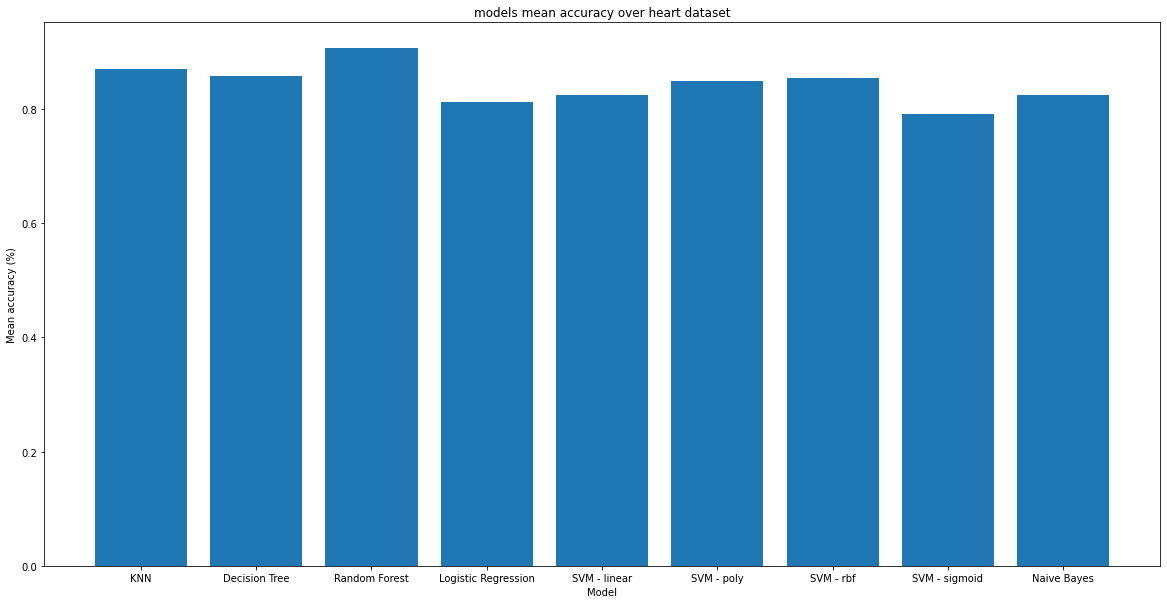

In [23]:
plt.rcParams["figure.figsize"] = (20,10)

plt.bar(models,mean_accuracy)
plt.xlabel('Model')
plt.ylabel("Mean accuracy (%)")
plt.title('models mean accuracy over heart dataset')
plt.show()

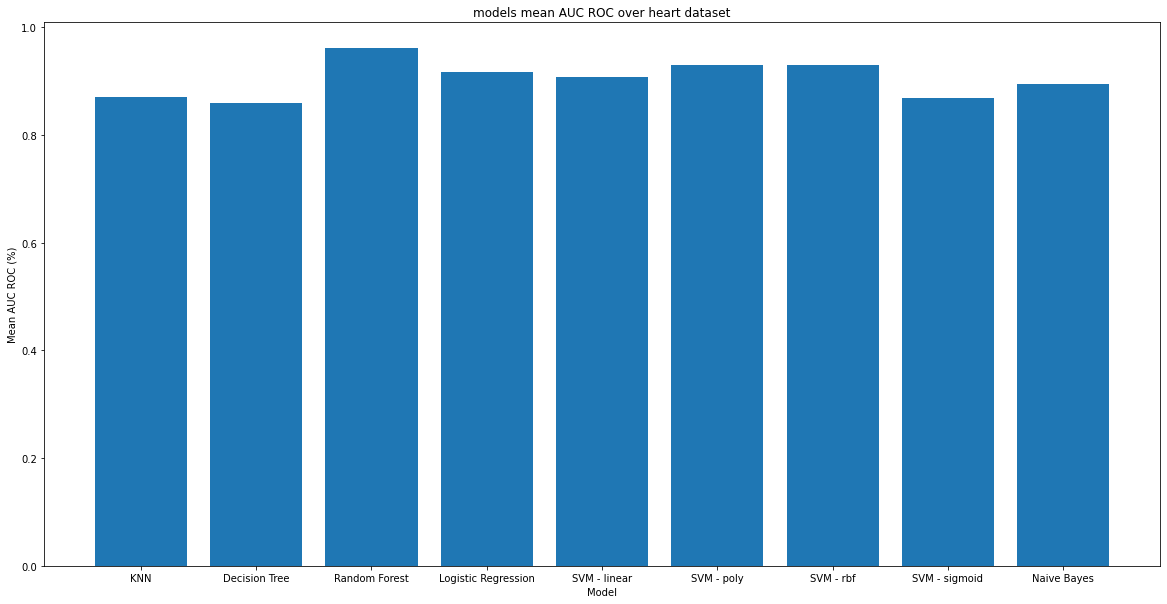

In [24]:
plt.bar(models,mean_auc_roc)
plt.xlabel('Model')
plt.ylabel("Mean AUC ROC (%)")
plt.title('models mean AUC ROC over heart dataset')
plt.show()

Random first is the most suited model for this mission. 